In [1]:
# -*- coding: utf-8 -*-
"""
Combined and Refactored Notebook for SIMPLE-O RAG System
This script consolidates setup, data preprocessing, model loading,
RAG execution, and evaluation into a single, more efficient workflow.
"""

#==============================================================================
# BAGIAN 1: PENGATURAN GLOBAL, INSTALASI, DAN PEMUATAN DATA
#==============================================================================

# --- 1.1. Instalasi Pustaka ---
# Instalasi semua pustaka yang diperlukan untuk keseluruhan proses.
!pip install python-docx fugashi ipadic unidic-lite sentence-transformers faiss-cpu
!pip install mecab-python3 accelerate bitsandbytes
!pip install tensorflow ragas
!python -m unidic download

# --- 1.2. Impor Pustaka ---
# -*- coding: utf-8 -*-
"""
1_Data_Preprocessing_and_Knowledge_Base_Creation.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/
"""
#tagger = MeCab.Tagger("-Owakati -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
#print(tagger.parse("すもももももももものうち"))

# Import yang diperlukan
import os
import re
import json
import time
import numpy as np
import pandas as pd
import docx
import MeCab
import torch
import faiss
import tensorflow as tf
from google.colab import drive
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import backend as K
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_recall, context_precision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 97.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 44.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.4/698.4 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# --- 1.3. Konfigurasi Awal & Mount Drive ---
drive.mount('/content/gdrive')

# Definisikan semua path di satu tempat
BASE_PATH = "/content/gdrive/MyDrive/Skripsi_Rezki-Muhammad/Project/"
DATASET_PATH = os.path.join(BASE_PATH, "Dataset/")
KB_PATH = os.path.join(BASE_PATH, "KnowledgeBase/")
MODEL_PATH = os.path.join(BASE_PATH, "Model/")
os.makedirs(KB_PATH, exist_ok=True)

REF_DOC_PATH = os.path.join(DATASET_PATH, "referensi.docx")
SOAL_DOC_PATH = os.path.join(DATASET_PATH, "soal.docx")
KEY_DIR_PATH = os.path.join(DATASET_PATH, "key/")
TEST_DIR_PATH = os.path.join(DATASET_PATH, "test/")
VOCAB_PATH = os.path.join(KB_PATH, "vocabulary.pkl")

print(BASE_PATH)
print(DATASET_PATH)
print(KB_PATH)
print(MODEL_PATH)

print("\n=== Pemeriksaan Lingkungan GPU & CUDA ===")
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"Jumlah GPU Fisik yang Tersedia: {len(gpu_devices)}")

if gpu_devices:
    print("Detail GPU:")
    for i, gpu in enumerate(gpu_devices):
        print(f"  GPU {i}: {gpu}")
        try:
            details = tf.config.experimental.get_device_details(gpu)
            print(f"    Nama Perangkat: {details.get('device_name', 'N/A')}")
            print(f"    Compute Capability: {details.get('compute_capability', 'N/A')}")
            # Checking for cuDNN presence is harder directly via public TF API
            # But if compute_capability is shown, it's a good sign
        except Exception as e:
             print(f"    Gagal mendapatkan detail perangkat: {e}")

    # Try a simple GPU operation to test the path
    try:
        with tf.device('/GPU:0'):
            a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
            c = tf.matmul(a, b)
            print("\nTes operasi GPU sederhana berhasil:")
            print(c.numpy())
    except Exception as e:
        print(f"\nERROR: Tes operasi GPU sederhana gagal: {e}")
        print("Ini mungkin menunjukkan masalah dengan instalasi CUDA/cuDNN atau konfigurasi TensorFlow.")

else:
    print("Tidak ada GPU fisik terdeteksi.")
    print("TensorFlow akan menggunakan CPU.")

print("=== Selesai Pemeriksaan Lingkungan ===")

Mounted at /content/gdrive
/content/gdrive/MyDrive/Skripsi_Rezki-Muhammad/Project/
/content/gdrive/MyDrive/Skripsi_Rezki-Muhammad/Project/Dataset/
/content/gdrive/MyDrive/Skripsi_Rezki-Muhammad/Project/KnowledgeBase/
/content/gdrive/MyDrive/Skripsi_Rezki-Muhammad/Project/Model/

=== Pemeriksaan Lingkungan GPU & CUDA ===
Jumlah GPU Fisik yang Tersedia: 0
Tidak ada GPU fisik terdeteksi.
TensorFlow akan menggunakan CPU.
=== Selesai Pemeriksaan Lingkungan ===


In [4]:
# --- 1.4. Fungsi Pembantu (Helper Functions) ---
# Inisialisasi MeCab Tagger
tagger = MeCab.Tagger("-Owakati")

def preprocess_japanese_text(text):
    """Membersihkan dan melakukan tokenisasi pada teks Jepang."""
    text = re.sub(r'\\s+', '', str(text))
    return tagger.parse(text).strip()

def read_docx_by_delimiter(file_path, delimiter_pattern):
    """Fungsi generik untuk membaca file .docx dan membaginya berdasarkan delimiter regex."""
    doc = docx.Document(file_path)
    full_text = "\\n".join([para.text for para in doc.paragraphs])
    sections = re.split(delimiter_pattern, full_text)
    return [section.strip() for section in sections if section.strip()]

In [6]:
# --- 1.5. Pemuatan dan Pra-pemrosesan Data ---
print("Memuat dan memproses semua data awal...")

# A. Data Soal & Referensi
questions_raw_list = read_docx_by_delimiter(SOAL_DOC_PATH, r'====SOAL \\d+====')
references_raw_list = read_docx_by_delimiter(REF_DOC_PATH, r'====SOAL \\d+====')

question_data = [{"question_id": f"Q{i+1}", "question_text": preprocess_japanese_text(q)} for i, q in enumerate(questions_raw_list)]
print(f"Ditemukan {len(question_data)} soal dan {len(references_raw_list)} bagian referensi.")

# B. Data Kunci Jawaban
key_answers_data = []
for i in range(1, 6):
    key_doc_path = os.path.join(KEY_DIR_PATH, f"jwbDosen{i}.docx")
    if os.path.exists(key_doc_path):
        variations = read_docx_by_delimiter(key_doc_path, "====VAR====")
        for j, var_text in enumerate(variations):
            key_answers_data.append({
                "question_id": f"Q{i}",
                "answer_id": f"Q{i}_KA{j+1}",
                "text": preprocess_japanese_text(var_text)
            })
print(f"Total {len(key_answers_data)} variasi kunci jawaban diproses.")

# C. Data Jawaban Mahasiswa
student_answers_data = []
for i in range(1, 31):
    student_doc_path = os.path.join(TEST_DIR_PATH, f"mahasiswa{i}.docx")
    if os.path.exists(student_doc_path):
        answers_list = read_docx_by_delimiter(student_doc_path, "====Jawaban====")
        if len(answers_list) != 5:
            print(f"Warning: Mahasiswa {i} memiliki {len(answers_list)} jawaban, diharapkan 5.")
        for q_idx, ans_text in enumerate(answers_list):
            student_answers_data.append({
                "student_id": f"M{i}",
                "question_id": f"Q{q_idx+1}",
                "original_text": ans_text,
                "processed_text": preprocess_japanese_text(ans_text)
            })
print(f"Total {len(student_answers_data)} jawaban siswa diproses.")


Memuat dan memproses semua data awal...
Ditemukan 1 soal dan 1 bagian referensi.
Total 18 variasi kunci jawaban diproses.
Total 150 jawaban siswa diproses.


In [5]:
from huggingface_hub import login
from google.colab import userdata
login(token=userdata.get('RAG_Gemma'))


# --- 2.1. Muat Model SBERT untuk Embeddings ---
sbert_model_name = "sonoisa/sentence-bert-base-ja-mean-tokens"
sbert_tokenizer = AutoTokenizer.from_pretrained(sbert_model_name)
sbert_model = AutoModel.from_pretrained(sbert_model_name)
sbert_model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
sbert_model.to(device)
print(f"Model SBERT '{sbert_model_name}' dimuat ke {device}.")

def get_embeddings(texts):
    """Menghasilkan embedding untuk daftar teks menggunakan SBERT."""
    inputs = sbert_tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        embeddings = sbert_model(**inputs).last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Model SBERT 'sonoisa/sentence-bert-base-ja-mean-tokens' dimuat ke cpu.


In [8]:
# --- 2.3. Muat Model SIMPLE-O CNN-BILSTM (Perbaikan Shape Mismatch) ---
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Lambda, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import os
import pickle

MODEL_PATH = '/content/gdrive/MyDrive/Skripsi_Rezki-Muhammad/Project/Model'
MODEL_WEIGHTS_PATH = os.path.join(MODEL_PATH, "cnnbilstm_model0.h5")
VOCAB_PATH = os.path.join(KB_PATH, "vocabulary.pkl")

def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# Cek ketersediaan GPU (Keep this for overall context, but we'll explicitly use CPU below)
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU tersedia untuk TensorFlow.")
    # We will explicitly use CPU for the SIMPLE-O model below
else:
    print("Tidak ada GPU tersedia untuk TensorFlow.")

simple_o_model = None
tokenizer_simpleo = None

try:
    print("Membangun arsitektur model secara manual (Memaksa menggunakan CPU)...")

    # Muat tokenizer
    print(f"Mencoba memuat tokenizer dari: {VOCAB_PATH}")
    with open(VOCAB_PATH, 'rb') as f:
        tokenizer_simpleo = pickle.load(f)
    print("Tokenizer berhasil dimuat.")

    # Definisikan parameter utama model
    INPUT_SHAPE = (81,)
    VOCAB_SIZE = 2511
    EMBEDDING_DIM = 300
    print(f"Ukuran vocabulary DIATUR SECARA MANUAL menjadi: {VOCAB_SIZE} agar sesuai dengan model .h5")

    # --- PERUBAHAN DI SINI: Menggunakan tf.device('/CPU:0') ---
    with tf.device('/CPU:0'): # Explicitly build and load the model on CPU
        input_1 = Input(shape=INPUT_SHAPE, dtype='int32', name='input_1')
        input_2 = Input(shape=INPUT_SHAPE, dtype='int32', name='input_2')

        # Layer Embedding
        embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, trainable=False, name='embedding')

        # Sisa arsitektur sama seperti sebelumnya
        # These layers will now also be built and executed on the CPU
        conv_layer = Conv1D(filters=64, kernel_size=5, activation='relu', name='conv1d')
        pooling_layer = MaxPooling1D(pool_size=4, name='max_pooling1d')
        dropout_layer = Dropout(0.0, name='dropout')
        bilstm_layer = Bidirectional(LSTM(50), name='bidirectional')

        def create_encoder(input_tensor):
            x = embedding_layer(input_tensor)
            x = conv_layer(x)
            x = pooling_layer(x)
            x = dropout_layer(x)
            encoded = bilstm_layer(x)
            return encoded

        encoded_1 = create_encoder(input_1)
        encoded_2 = create_encoder(input_2)

        distance_layer = Lambda(lambda tensors: exponent_neg_manhattan_distance(tensors[0], tensors[1]), name='lambda')([encoded_1, encoded_2])
        output_layer = Dense(11, activation='softmax', name='dense')(distance_layer)

        simple_o_model = Model(inputs=[input_1, input_2], outputs=output_layer)
        print("Arsitektur model berhasil dibuat (dipaksa di CPU).")

        # Muat bobot (weights)
        if os.path.exists(MODEL_WEIGHTS_PATH):
            simple_o_model.load_weights(MODEL_WEIGHTS_PATH)
            print("Bobot (weights) berhasil dimuat (di CPU).")
        else:
            print(f"ERROR: File bobot model tidak ditemukan di '{MODEL_WEIGHTS_PATH}'.")
            simple_o_model = None

    if simple_o_model:
        print("\nModel SIMPLE-O berhasil dimuat sepenuhnya (di CPU).")
        simple_o_model.summary()

        # --- Add Compilation Step Here (within CPU context) ---
        # This might re-optimize the graph for the CPU target after loading weights
        with tf.device('/CPU:0'):
            print("Mengompilasi ulang model SIMPLE-O di CPU...")
            # Use an optimizer, loss, and metrics suitable for your original training
            # Using dummy values if original training config is unknown
            simple_o_model.compile(optimizer='adam',
                                   loss='categorical_crossentropy', # Assuming multi-class score classification
                                   metrics=['accuracy'])
            print("Model SIMPLE-O berhasil dikompilasi ulang di CPU.")
        # --- End Compilation Step ---

    else:
        print("\nModel SIMPLE-O gagal dimuat.")

except FileNotFoundError:
    print(f"ERROR: File tokenizer '{VOCAB_PATH}' tidak ditemukan. Proses dibatalkan.")
    simple_o_model = None
except Exception as e:
    print(f"Gagal memuat model: {e}")
    import traceback
    traceback.print_exc()
    simple_o_model = None

Tidak ada GPU tersedia untuk TensorFlow.
Membangun arsitektur model secara manual (Memaksa menggunakan CPU)...
Mencoba memuat tokenizer dari: /content/gdrive/MyDrive/Skripsi_Rezki-Muhammad/Project/KnowledgeBase/vocabulary.pkl
Tokenizer berhasil dimuat.
Ukuran vocabulary DIATUR SECARA MANUAL menjadi: 2511 agar sesuai dengan model .h5
Arsitektur model berhasil dibuat (dipaksa di CPU).
Bobot (weights) berhasil dimuat (di CPU).

Model SIMPLE-O berhasil dimuat sepenuhnya (di CPU).


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 81)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 81)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 81, 300)   │    753,300 │ input_1[0][0],    │
│ (Embedding)         │                   │            │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 77, 64)    │     96,064 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 19, 64)    │          0 │ conv1d[0][0],     │
│ (MaxPooling1D)      │                   │            │ conv1d[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 19, 64)    │          0 │ max_pooling1d[0]… │
│                     │                   │            │ max_pooling1d[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100)       │     46,000 │ dropout[0][0],    │
│ (Bidirectional)     │                   │            │ dropout[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ bidirectional[0]… │
│                     │                   │            │ bidirectional[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 11)        │         22 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 895,386 (3.42 MB)

 Trainable params: 142,086 (555.02 KB)

 Non-trainable params: 753,300 (2.87 MB)

Mengompilasi ulang model SIMPLE-O di CPU...
Model SIMPLE-O berhasil dikompilasi ulang di CPU.


In [23]:
# --- 2.3. Muat Model SIMPLE-O CNN-BILSTM (Versi CPU) ---
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Lambda, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import pickle

# Path tetap sama
MODEL_PATH = '/content/gdrive/MyDrive/Skripsi_Rezki-Muhammad/Project/Model'
MODEL_WEIGHTS_PATH = os.path.join(MODEL_PATH, "cnnbilstm_model0.h5")
VOCAB_PATH = os.path.join(KB_PATH, "vocabulary.pkl")

def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

simple_o_model = None
tokenizer_simpleo = None

try:
    print("Membangun arsitektur model secara manual...")

    # Muat tokenizer
    with open(VOCAB_PATH, 'rb') as f:
        tokenizer_simpleo = pickle.load(f)
    print("Tokenizer berhasil dimuat.")

    # Definisikan parameter model
    INPUT_SHAPE = (81,)
    VOCAB_SIZE = 2511
    EMBEDDING_DIM = 300

    # Karena GPU sudah dinonaktifkan, model ini akan otomatis dibuat di CPU
    input_1 = Input(shape=INPUT_SHAPE, dtype='int32', name='input_1')
    input_2 = Input(shape=INPUT_SHAPE, dtype='int32', name='input_2')
    embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, trainable=False, name='embedding')
    conv_layer = Conv1D(filters=64, kernel_size=5, activation='relu', name='conv1d')
    pooling_layer = MaxPooling1D(pool_size=4, name='max_pooling1d')
    dropout_layer = Dropout(0.0, name='dropout')
    bilstm_layer = Bidirectional(LSTM(50), name='bidirectional')

    def create_encoder(input_tensor):
        x = embedding_layer(input_tensor)
        x = conv_layer(x)
        x = pooling_layer(x)
        x = dropout_layer(x)
        encoded = bilstm_layer(x)
        return encoded

    encoded_1 = create_encoder(input_1)
    encoded_2 = create_encoder(input_2)

    distance_layer = Lambda(lambda tensors: exponent_neg_manhattan_distance(tensors[0], tensors[1]), name='lambda')([encoded_1, encoded_2])
    output_layer = Dense(11, activation='softmax', name='dense')(distance_layer)

    simple_o_model = Model(inputs=[input_1, input_2], outputs=output_layer)
    print("Arsitektur model berhasil dibuat.")

    # Muat bobot
    simple_o_model.load_weights(MODEL_WEIGHTS_PATH)
    print("Bobot (weights) berhasil dimuat.")
    print("\nModel SIMPLE-O berhasil dimuat sepenuhnya di CPU.")
    simple_o_model.summary()

except Exception as e:
    print(f"Gagal memuat model: {e}")
    simple_o_model = None

Membangun arsitektur model secara manual...
Tokenizer berhasil dimuat.
Arsitektur model berhasil dibuat.
Bobot (weights) berhasil dimuat.

Model SIMPLE-O berhasil dimuat sepenuhnya di CPU.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 81)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 81)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 81, 300)   │    753,300 │ input_1[0][0],    │
│ (Embedding)         │                   │            │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 77, 64)    │     96,064 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 19, 64)    │          0 │ conv1d[0][0],     │
│ (MaxPooling1D)      │                   │            │ conv1d[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 19, 64)    │          0 │ max_pooling1d[0]… │
│                     │                   │            │ max_pooling1d[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100)       │     46,000 │ dropout[0][0],    │
│ (Bidirectional)     │                   │            │ dropout[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ bidirectional[0]… │
│                     │                   │            │ bidirectional[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 11)        │         22 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 895,386 (3.42 MB)

 Trainable params: 142,086 (555.02 KB)

 Non-trainable params: 753,300 (2.87 MB)

# Batas Suci


In [21]:
# Pastikan semua variabel yang diperlukan sudah ada dari sel sebelumnya
if 'student_answers_data' in globals() and 'simple_o_model' in globals() and 'tokenizer_simpleo' in globals():

    print("Memulai proses penilaian untuk seluruh jawaban siswa...")

    # Gunakan dictionary untuk menyimpan hasil dengan struktur bersarang
    all_scores_dict = {}

    # Loop melalui setiap jawaban siswa yang sudah dibaca
    for student_ans in tqdm(student_answers_data, desc="Menilai Esai Mahasiswa"):

        student_id = student_ans['student_id']
        question_id = student_ans['question_id']

        # Panggil fungsi penilaian yang berjalan di CPU
        score = get_simple_o_score(
            student_answer_text=student_ans["processed_text"],
            question_id=question_id,
            model=simple_o_model,
            tokenizer=tokenizer_simpleo
        )

        # Buat entri untuk mahasiswa jika belum ada
        if student_id not in all_scores_dict:
            all_scores_dict[student_id] = {}

        # Simpan skor untuk question_id yang sesuai
        all_scores_dict[student_id][question_id] = {
            "student_answer": student_ans['original_text'],
            "simple_o_score": int(score) # Simpan sebagai integer
        }

    print("\nProses penilaian selesai.")
    print("-" * 50)

    # --- BAGIAN BARU: MENYIMPAN HASIL KE FILE JSON ---

    # 1. Definisikan path untuk file output JSON
    # File akan disimpan di folder KnowledgeBase/ yang sudah kita definisikan
    output_json_path = os.path.join(KB_PATH, "simple_o_scores.json")

    # 2. Simpan dictionary ke dalam file JSON
    try:
        with open(output_json_path, 'w', encoding='utf-8') as f:
            # json.dump menulis dictionary ke file
            # indent=4 membuat file JSON rapi dan mudah dibaca
            # ensure_ascii=False penting untuk menyimpan karakter Jepang dengan benar
            json.dump(all_scores_dict, f, ensure_ascii=False, indent=4)

        print(f"Hasil penilaian berhasil disimpan ke: {output_json_path}")

        # 3. (Opsional) Tampilkan beberapa hasil pertama dari file yang baru dibuat
        print("\nContoh isi file JSON:")
        print(json.dumps(dict(list(all_scores_dict.items())[:2]), ensure_ascii=False, indent=4))

    except Exception as e:
        print(f"Terjadi error saat menyimpan file JSON: {e}")

else:
    print("Error: Variabel prasyarat tidak ditemukan. Pastikan sel-sel sebelumnya sudah dijalankan.")

Memulai proses penilaian untuk seluruh jawaban siswa...


Menilai Esai Mahasiswa:   0%|          | 0/150 [00:00<?, ?it/s]

Error saat menghitung skor untuk Soal Q1 (Jawaban Siswa: '小 学校 の クラス 単位 の 投票 で 最多 得票 の 作品 が マスコット に 決め られ まし...'): int() argument must be a string, a bytes-like object or a real number, not 'NoneType'


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

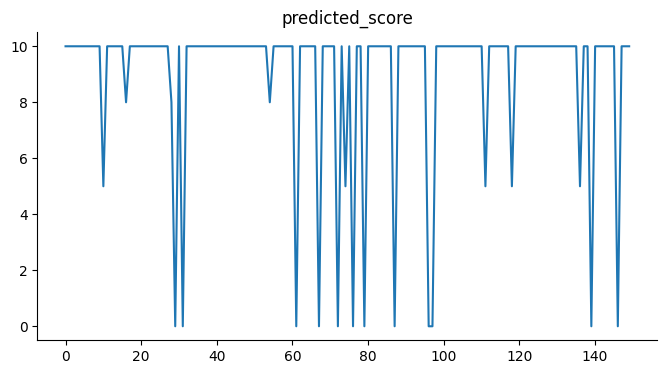

In [ ]:
# @title predicted_score

from matplotlib import pyplot as plt
results_df['predicted_score'].plot(kind='line', figsize=(8, 4), title='predicted_score')
plt.gca().spines[['top', 'right']].set_visible(False)

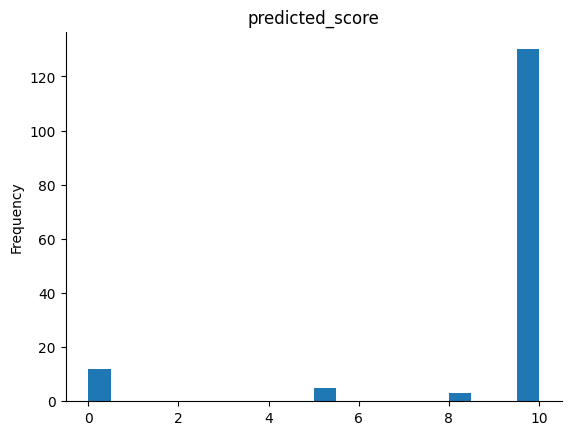

In [ ]:
# @title predicted_score

from matplotlib import pyplot as plt
results_df['predicted_score'].plot(kind='hist', bins=20, title='predicted_score')
plt.gca().spines[['top', 'right',]].set_visible(False)